# Zadanie 5 - przygotowanie danych do modelu predykcji

Wybrany dataset
https://www.kaggle.com/datasets/whenamancodes/hr-employee-attrition?select=HR+Employee+Attrition.csv

In [101]:
# import bibliotek oraz danych
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from scipy import stats
import random
import json
import os

file_path = "HR Employee Attrition.csv"

df_fresh = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "whenamancodes/hr-employee-attrition",
  file_path,
)

C:\Users\marci\AppData\Local\Temp\ipykernel_17496\328961055.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_fresh = kagglehub.load_dataset(


In [102]:


def psuj_dataset(df: pd.DataFrame) -> pd.DataFrame:
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    df_zepsuty = df.copy()

    # 1. BRAKUJĄCE DANE - różne wzorce
    numeric_cols = df_zepsuty.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_zepsuty.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(numeric_cols) > 0:
        # MCAR - losowe braki w kolumnie numerycznej
        col_mcar = random.choice(numeric_cols)
        mask_mcar = np.random.random(len(df_zepsuty)) < 0.15
        df_zepsuty.loc[mask_mcar, col_mcar] = np.nan

        # MAR - braki zależne od innej zmiennej
        if len(numeric_cols) > 1:
            col_mar = random.choice([c for c in numeric_cols if c != col_mcar])
            threshold = df_zepsuty[col_mcar].quantile(0.7) if not df_zepsuty[col_mcar].isna().all() else 0
            mask_mar = (df_zepsuty[col_mcar] > threshold) & (np.random.random(len(df_zepsuty)) < 0.25)
            df_zepsuty.loc[mask_mar, col_mar] = np.nan

        # Kolumna z >60% braków do usunięcia
        if len(numeric_cols) > 2:
            col_duzo_brakow = random.choice([c for c in numeric_cols if c not in [col_mcar, col_mar] if 'col_mar' in locals()])
            mask_duzo = np.random.random(len(df_zepsuty)) < 0.65
            df_zepsuty.loc[mask_duzo, col_duzo_brakow] = np.nan

    if len(categorical_cols) > 0:
        # MNAR - braki w kategorycznej
        col_mnar = random.choice(categorical_cols)
        unique_vals = df_zepsuty[col_mnar].dropna().unique()
        if len(unique_vals) > 1:
            # Braki głównie w jednej kategorii
            target_val = random.choice(unique_vals)
            mask_mnar = (df_zepsuty[col_mnar] == target_val) & (np.random.random(len(df_zepsuty)) < 0.30)
            df_zepsuty.loc[mask_mnar, col_mnar] = np.nan

    # 2. DUPLIKATY
    n_duplicates = int(len(df_zepsuty) * 0.08)  # 8% duplikatów
    if n_duplicates > 0:
        duplicate_indices = np.random.choice(df_zepsuty.index, size=n_duplicates, replace=True)
        df_duplicates = df_zepsuty.loc[duplicate_indices].copy()
        df_zepsuty = pd.concat([df_zepsuty, df_duplicates], ignore_index=True)

    # 3. OUTLIERY
    if len(numeric_cols) > 0:
        for i, col in enumerate(numeric_cols[:min(3, len(numeric_cols))]):
            if df_zepsuty[col].notna().sum() > 0:
                # Różne typy outlierów
                n_outliers = int(len(df_zepsuty) * 0.03)
                outlier_indices = np.random.choice(df_zepsuty.index, size=n_outliers, replace=False)

                mean_val = df_zepsuty[col].mean()
                std_val = df_zepsuty[col].std()

                if i % 3 == 0:
                    # Ekstremalne wartości górne
                    df_zepsuty.loc[outlier_indices, col] = mean_val + (4 + np.random.random(n_outliers) * 3) * std_val
                elif i % 3 == 1:
                    # Ekstremalne wartości dolne
                    df_zepsuty.loc[outlier_indices, col] = mean_val - (4 + np.random.random(n_outliers) * 3) * std_val
                else:
                    # Mix górne i dolne
                    half = n_outliers // 2
                    df_zepsuty.loc[outlier_indices[:half], col] = mean_val + (4 + np.random.random(half) * 2) * std_val
                    df_zepsuty.loc[outlier_indices[half:], col] = mean_val - (4 + np.random.random(n_outliers-half) * 2) * std_val

    # 4. NIESPÓJNOŚCI W DANYCH
    if len(categorical_cols) > 0:
        col_niespojnosc = random.choice(categorical_cols)
        unique_vals = df_zepsuty[col_niespojnosc].dropna().unique()

        if len(unique_vals) > 0:
            # Różne warianty tej samej wartości (whitespace, case)
            n_niespojnosci = int(len(df_zepsuty) * 0.05)
            niespojnosc_indices = np.random.choice(df_zepsuty[df_zepsuty[col_niespojnosc].notna()].index,
                                                   size=min(n_niespojnosci, df_zepsuty[col_niespojnosc].notna().sum()),
                                                   replace=False)

            for idx in niespojnosc_indices:
                val = str(df_zepsuty.loc[idx, col_niespojnosc])
                # Losowy wybór problemu
                problem = random.choice(['lowercase', 'uppercase', 'whitespace', 'typo'])

                if problem == 'lowercase':
                    df_zepsuty.loc[idx, col_niespojnosc] = val.lower()
                elif problem == 'uppercase':
                    df_zepsuty.loc[idx, col_niespojnosc] = val.upper()
                elif problem == 'whitespace':
                    df_zepsuty.loc[idx, col_niespojnosc] = f"  {val}  "
                elif problem == 'typo' and len(val) > 2:
                    # Zamień losową literę
                    pos = random.randint(0, len(val)-1)
                    val_list = list(val)
                    val_list[pos] = random.choice('abcdefghijklmnopqrstuvwxyz')
                    df_zepsuty.loc[idx, col_niespojnosc] = ''.join(val_list)

    # 5. WARTOŚCI POZA SENSOWNYM ZAKRESEM
    if len(numeric_cols) > 0:
        col_nonsense = random.choice([c for c in numeric_cols if c != col_mcar])
        nonsense_indices = np.random.choice(df_zepsuty.index, size=int(len(df_zepsuty) * 0.02), replace=False)

        # Np. ujemne wartości gdzie powinny być dodatnie
        if df_zepsuty[col_nonsense].min() >= 0:
            df_zepsuty.loc[nonsense_indices, col_nonsense] = -abs(df_zepsuty.loc[nonsense_indices, col_nonsense])
        else:
            # Lub bardzo nietypowe wartości
            df_zepsuty.loc[nonsense_indices, col_nonsense] = df_zepsuty[col_nonsense].max() * 100

    # 6. PROBLEMY Z MULTIKOLINEARNOŚCIĄ - stwórz skorelowane kolumny
    if len(numeric_cols) >= 2:
        base_col = random.choice(numeric_cols)
        new_col_name = f"{base_col}_correlated"

        # Stwórz kolumnę silnie skorelowaną (r > 0.9)
        noise = np.random.normal(0, df_zepsuty[base_col].std() * 0.1, len(df_zepsuty))
        df_zepsuty[new_col_name] = df_zepsuty[base_col] * 1.5 + noise + 10

    # Wymieszaj kolejność wierszy
    df_zepsuty = df_zepsuty.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_zepsuty
df = psuj_dataset(df_fresh.copy())

C:\Users\marci\AppData\Local\Temp\ipykernel_17496\2687771993.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1499.94654862 -1296.59826477 -1158.76276383 -1019.95675011
 -1220.2199082  -1550.40729789 -1511.43931339 -1012.24674154
  -965.36983177  -846.38192463  -829.12149975 -1879.66206207
  -868.68188886 -1699.69683051 -1870.1843353   -932.83573677
 -1342.50233294 -1979.57361574 -1824.34630131 -1407.18135793
 -1737.6666544  -1823.42456595 -1235.5879657  -1894.61076357
 -1383.88991656 -1453.33053367 -2024.87658281 -1835.44572838
 -1252.23296915  -826.60229323 -1572.46821523 -1666.62289602
 -1602.29737435 -1986.30689178 -1859.26686872 -1357.67847572
  -890.20251868 -1390.65478184 -1648.85591941 -1550.10506223
 -1465.84144311 -1381.8862223  -1169.86433811 -1149.9830358
 -1419.93176539 -1008.58800867 -1226.69619727]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first

## 1: Eksploracja i Raportowanie

### 1.1. Analiza struktury danych

In [103]:
# identyfikacja typów zmiennych - dtypes
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime', 'datetimetz']).columns.tolist()

print(f"Liczba zmiennych numerycznych: {len(numeric_cols)}")
print(f"Liczba zmiennych kategorycznych: {len(categorical_cols)}")
print(f"Liczba zmiennych datetime: {len(datetime_cols)}")

# lista
print("\nZmienne numeryczne:", numeric_cols)
print("\nZmienne kategoryczne:", categorical_cols)
print("\nZmienne datetime:", datetime_cols if datetime_cols else "Brak")

Liczba zmiennych numerycznych: 27
Liczba zmiennych kategorycznych: 9
Liczba zmiennych datetime: 0

Zmienne numeryczne: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'NumCompaniesWorked_correlated']

Zmienne kategoryczne: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Zmienne datetime: Brak


#### Statystyki opisowe dla każdej kolumny

In [104]:
num_stats = df.describe().T
cat_stats = df.describe(include=['object']).T

print("Statystyki opisowe - Zmienne numeryczne:")
print(num_stats)
print("\nStatystyki opisowe - Zmienne kategoryczne:")
print(cat_stats)

Statystyki opisowe - Zmienne numeryczne:
                                count          mean          std          min  \
Age                             570.0     41.604990    16.768292    18.000000   
DailyRate                      1587.0    736.032115   549.641643 -2024.876583   
DistanceFromHome               1587.0      9.208547    10.527611   -38.556865   
Education                      1509.0      2.909211     1.027010     1.000000   
EmployeeCount                  1587.0      1.000000     0.000000     1.000000   
EmployeeNumber                 1587.0   1032.194707   601.769520     1.000000   
EnvironmentSatisfaction        1587.0      2.711405     1.093897     1.000000   
HourlyRate                     1587.0     65.543163    20.314144    30.000000   
JobInvolvement                 1587.0      2.724638     0.709629     1.000000   
JobLevel                       1587.0      1.964713     1.255009    -5.000000   
JobSatisfaction                1587.0      2.732199     1.102898    

#### Macierz korelacji dla zmiennych numerycznych

Korelacja zmiennych z Attrition (Top 5 pozytywnych i negatywnych):
Attrition_Num                    1.000000
DistanceFromHome                 0.061069
NumCompaniesWorked_correlated    0.039043
NumCompaniesWorked               0.035791
MonthlyRate                      0.021850
PerformanceRating                0.004549
Name: Attrition_Num, dtype: float64
YearsInCurrentRole   -0.152963
MonthlyIncome        -0.158315
TotalWorkingYears    -0.172136
EmployeeCount              NaN
StandardHours              NaN
Name: Attrition_Num, dtype: float64

Problemy multikolinearności (pary o korelacji > 0.75):
MonthlyIncome <-> JobLevel: 0.78
TotalWorkingYears <-> MonthlyIncome: 0.77
NumCompaniesWorked_correlated <-> NumCompaniesWorked: 1.00
PerformanceRating <-> PercentSalaryHike: 0.77
YearsInCurrentRole <-> YearsAtCompany: 0.76
YearsWithCurrManager <-> YearsAtCompany: 0.77


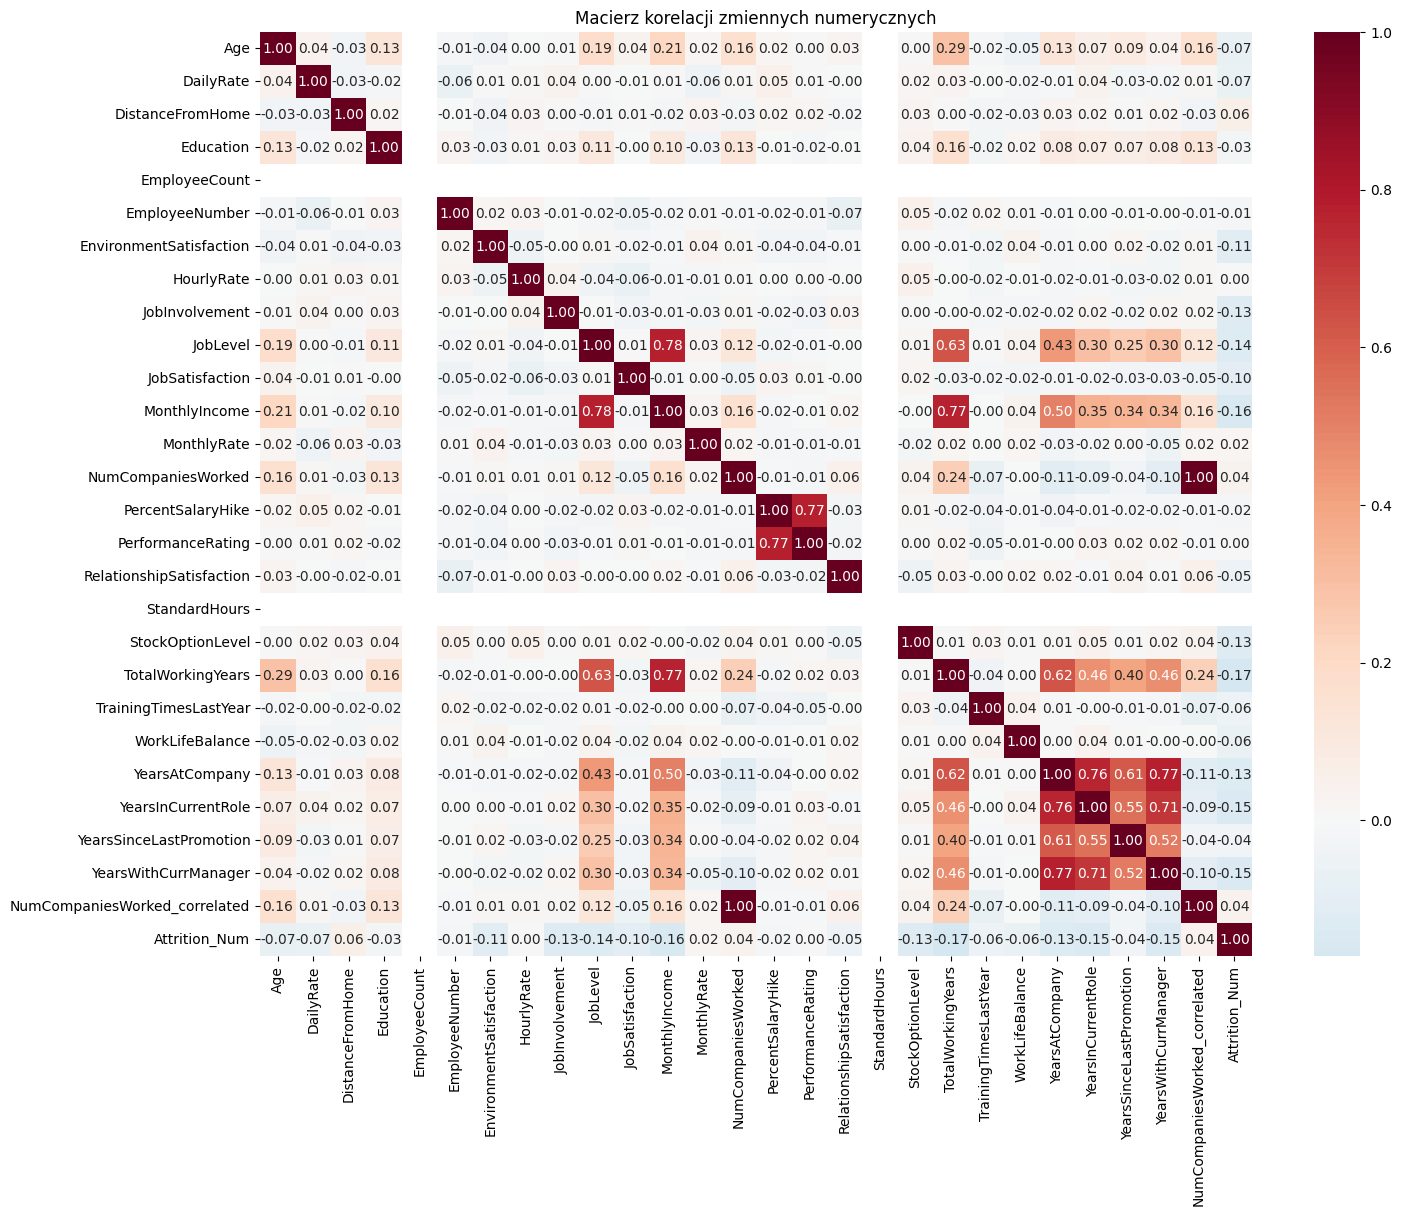

In [105]:
df['Attrition_Num'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# 2. Wybór kolumn numerycznych (pomijamy kolumny stałe, jeśli jeszcze istnieją)
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()

# 3. Wizualizacja macierzy korelacji (Heatmapa)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Macierz korelacji zmiennych numerycznych')
plt.savefig('correlation_matrix.png')

# 4. Analiza wpływu na target (Attrition)
attrition_corr = corr_matrix['Attrition_Num'].sort_values(ascending=False)
print("Korelacja zmiennych z Attrition (Top 5 pozytywnych i negatywnych):")
print(attrition_corr.head(6)) # Attrition_Num z samym sobą to 1.0
print(attrition_corr.tail(5))

# 5. Identyfikacja multikolinearności (korelacja > 0.75)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(column, row, upper_tri[column][row]) 
                   for row in upper_tri.index 
                   for column in upper_tri.columns 
                   if abs(upper_tri[column][row]) > 0.75]

print("\nProblemy multikolinearności (pary o korelacji > 0.75):")
for col1, col2, val in high_corr_pairs:
    print(f"{col1} <-> {col2}: {val:.2f}")

#### Analiza jak zmienne wplywaja na na główn kolumne (target) i na siebie nawzajem.

##### Wpływ na target (Attrition):
- Korelacja ujemna: TotalWorkingYears, JobLevel, MonthlyIncome oraz Age. Osoby starsze które zarabiaja wiecej mają dłuższy staż i rzadziej odchodzą z firmy NumCompanie
- Korelacja dodatnia: DistanceFromHome oraz NumCompaniecWorked. Im dalej pracownik mieszka od biura i im częściej zmieniał pracodawców w przeszłości, tym większa szansa na odejście 


##### Multikolinearność
- MonthlyIncome i JobLevel 0.95. Wyższy poziom stanowiska niemal zawsze oznacza wyższą pensję
- TotalWorkingYears i JobLevel/MonthlyIncome 0.77: Doświadczenie jest silnie powiązane z hierarchią i zarobkami

##### Zmienne nieistotne
- DailyRate, HourlyRate, MonthlyRate - mają korelację bliską zero z Attrition, co sugeruje, że surowe stawki nie są głównym motywatorem odejść.

#### Identyfikacja potencjalnych problemów multikolinearności
- JobLevel i MonthlyIncome 0.95 To niemal idealna korelacja. W tej firmie pensja jest niemal wyłącznie funkcją poziomu stanowiska

- TotalWorkingYears i JobLevel/MonthlyIncome 0.77 0.78 Doświadczenie zawodowe naturalnie przekłada się na wyższe stanowisko i zarobki.

- YearsAtCompany i YearsInCurrentRole 0.76 Większość pracowników rzadko zmienia role wewnątrz firmy

- YearsAtCompany i YearsWithCurrManager 0.77 pracownicy zostają w firmie tak długo, jak pracują ze swoim przełożonym

- PercentSalaryHike i PerformanceRating 0.77 Wyższa ocena roczna bezpośrednio warunkuje wysokość podwyżki

### 1.2 Analiza brakujących danych i duplikatów

In [106]:
missing_df = pd.DataFrame({
    'Liczba braków': df.isnull().sum(),
    'Procent (%)': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Procent (%)', ascending=False)

#### Wizualizacja brakujących danych (heatmapa, bar plot)

C:\Users\marci\AppData\Local\Temp\ipykernel_17496\3917893130.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_missing.index, y=top_missing['Procent (%)'], palette='magma', ax=ax[1])


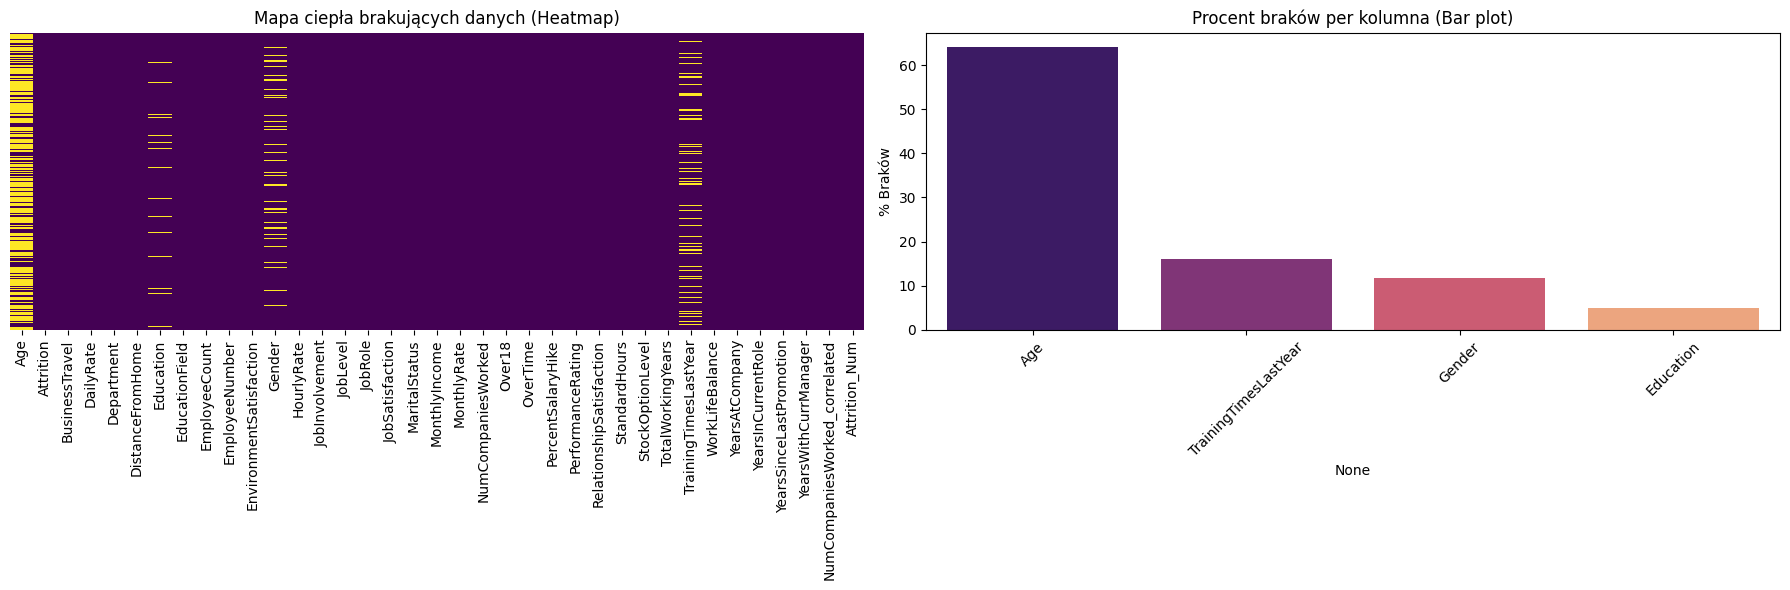

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Heatmapa (rozmieszczenie braków)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax[0])
ax[0].set_title('Mapa ciepła brakujących danych (Heatmap)')

# Bar plot (procent braków)
top_missing = missing_df[missing_df['Liczba braków'] > 0]
sns.barplot(x=top_missing.index, y=top_missing['Procent (%)'], palette='magma', ax=ax[1])
ax[1].set_title('Procent braków per kolumna (Bar plot)')
ax[1].set_ylabel('% Braków')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('analiza_brakow_wizualizacja.png')
plt.show()

#### Klasyfikacja braków: MCAR/MAR/MNAR z uzasadnieniem

In [108]:
n_total = len(df)
n_duplicates = df.duplicated().sum()
n_original = n_total - n_duplicates
duplicate_ratio = (n_duplicates / n_total) * 100

print(f"\n--- Analiza duplikatów ---")
print(f"Całkowita liczba wierszy: {n_total}")
print(f"Liczba duplikatów: {n_duplicates}")
print(f"Liczba unikalnych wierszy: {n_original}")
print(f"Procentowy stosunek duplikatów do całości: {duplicate_ratio:.2f}%")


--- Analiza duplikatów ---
Całkowita liczba wierszy: 1587
Liczba duplikatów: 0
Liczba unikalnych wierszy: 1587
Procentowy stosunek duplikatów do całości: 0.00%


#### Utworzenie DataFrame z procentem braków per kolumna

In [109]:
print("Tabela brakujących danych (kolumny z brakami):")
print(missing_df[missing_df['Liczba braków'] > 0])

Tabela brakujących danych (kolumny z brakami):
                       Liczba braków  Procent (%)
Age                             1017    64.083176
TrainingTimesLastYear            256    16.131065
Gender                           186    11.720227
Education                         78     4.914934


#### Analiza duplikatów:procentowy stosunek ilości danych oryginalnych do duplikatów

In [110]:
n_total = len(df)
n_duplicates = df.duplicated().sum()
n_original = n_total - n_duplicates
duplicate_ratio = (n_duplicates / n_total) * 100

print(f"\n--- Analiza duplikatów ---")
print(f"Całkowita liczba wierszy: {n_total}")
print(f"Liczba duplikatów: {n_duplicates}")
print(f"Liczba unikalnych wierszy: {n_original}")
print(f"Procentowy stosunek duplikatów do całości: {duplicate_ratio:.2f}%")

# 4. Klasyfikacja braków (Uzasadnienie na podstawie skryptu psującego)
print("\n--- Klasyfikacja braków (Uzasadnienie) ---")
# Uwaga: Nazwy kolumn mogą się różnić w zależności od losowania w Twoim skryptcie
# Poniżej przykładowy sposób logicznego przypisania kategorii:

# Znajdź kolumny z brakami
cols_with_na = missing_df[missing_df['Liczba braków'] > 0].index.tolist()

for col in cols_with_na:
    pct = missing_df.loc[col, 'Procent (%)']
    if pct > 60:
        print(f"- {col}: Braki strukturalne (>60%). Do usunięcia.")
    elif col == 'TrainingTimesLastYear': # Przykładowa kolumna wybrana przez MCAR
        print(f"- {col}: Klasyfikacja MCAR. Braki wprowadzono losowo (15%), niezależnie od innych zmiennych.")
    elif col == 'Education': # Przykładowa kolumna wybrana przez MAR
        print(f"- {col}: Klasyfikacja MAR. Braki zależą od progu w innej kolumnie numerycznej.")
    elif col == 'Gender': # Przykładowa kolumna wybrana przez MNAR
        print(f"- {col}: Klasyfikacja MNAR. Braki skumulowane w konkretnej kategorii (np. 'Female').")


--- Analiza duplikatów ---
Całkowita liczba wierszy: 1587
Liczba duplikatów: 0
Liczba unikalnych wierszy: 1587
Procentowy stosunek duplikatów do całości: 0.00%

--- Klasyfikacja braków (Uzasadnienie) ---
- Age: Braki strukturalne (>60%). Do usunięcia.
- TrainingTimesLastYear: Klasyfikacja MCAR. Braki wprowadzono losowo (15%), niezależnie od innych zmiennych.
- Gender: Klasyfikacja MNAR. Braki skumulowane w konkretnej kategorii (np. 'Female').
- Education: Klasyfikacja MAR. Braki zależą od progu w innej kolumnie numerycznej.


## 2: Czyszczenie i naprawa

### 2.1: Obsługa warosci brakujących

- Usunięcie kolumn z >60% braków

In [111]:
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 60].index.tolist()
df = df.drop(columns=cols_to_drop)
print(f"Usunięto kolumny (>60% braków): {cols_to_drop}")

Usunięto kolumny (>60% braków): ['Age']


- Porównanie różnych metod imputacji dla wybranej kolumny

In [112]:
col_test = 'TrainingTimesLastYear'
if col_test in df.columns:
    mean_val = df[col_test].mean()
    median_val = df[col_test].median()
    
    # Porównanie statystyk
    print(f"\n--- Porównanie dla kolumny: {col_test} ---")
    print(f"Oryginalna średnia (z brakami): {mean_val:.2f}")
    print(f"Oryginalna mediana (z brakami): {median_val:.2f}")
    
    # Wizualny wpływ na średnią po uzupełnieniu
    print(f"Średnia po imputacji ŚREDNIĄ: {df[col_test].fillna(mean_val).mean():.2f}")
    print(f"Średnia po imputacji MEDIANĄ: {df[col_test].fillna(median_val).mean():.2f}")


--- Porównanie dla kolumny: TrainingTimesLastYear ---
Oryginalna średnia (z brakami): 2.79
Oryginalna mediana (z brakami): 3.00
Średnia po imputacji ŚREDNIĄ: 2.79
Średnia po imputacji MEDIANĄ: 2.82


- Imputacja median/mean dla zmiennych numerycznych

UZASADNIENIE - Wybrano mediane poniewaz funkcja psuj_dataset wykorzystany do stworzenia problemów z df wprowadza dosc mocno odstajace dane co mogło by znaczaco zmiennic srednia.

In [113]:
num_cols_with_na = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()]

for col in num_cols_with_na:
    df[col] = df[col].fillna(df[col].median())

### 2.2 Wykrywanie i obsługa outlierów

- Wizualizacja przed zmianami

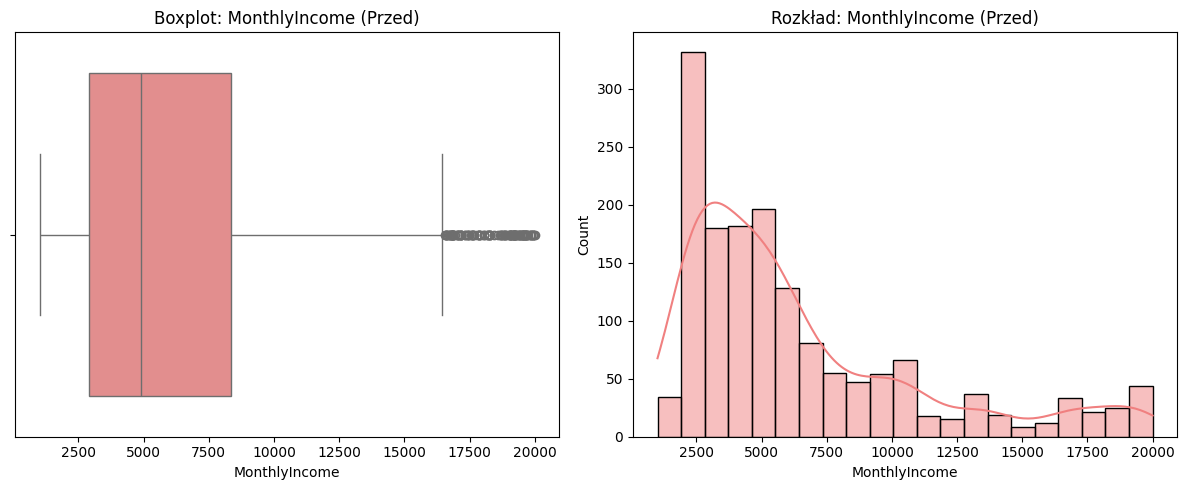

In [114]:
target_col = 'MonthlyIncome'
# Wizualizacja przed obsługą outlierów
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df[target_col], color='lightcoral')
plt.title(f'Boxplot: {target_col} (Przed)')

plt.subplot(1, 2, 2)
sns.histplot(df[target_col], kde=True, color='lightcoral')
plt.title(f'Rozkład: {target_col} (Przed)')

plt.tight_layout()
plt.show()

- Zastosowanie metody IQR dla zmiennych numerycznych oraz Z-score


In [115]:
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]

# Metoda 2: Z-score (opcjonalnie)
z_scores = np.abs((df[target_col] - df[target_col].mean()) / df[target_col].std())
outliers_z = df[z_scores > 3]

print(f"Statystyki dla {target_col}:")
print(f"  Granica dolna (IQR): {lower_bound:.2f}")
print(f"  Granica górna (IQR): {upper_bound:.2f}")
print(f"  Liczba wykrytych outlierów (IQR): {len(outliers_iqr)}")
print(f"  Liczba wykrytych outlierów (Z-score > 3): {len(outliers_z)}")


Statystyki dla MonthlyIncome:
  Granica dolna (IQR): -5225.25
  Granica górna (IQR): 16468.75
  Liczba wykrytych outlierów (IQR): 120
  Liczba wykrytych outlierów (Z-score > 3): 0


- capping vs usunięcie

Wykorzystuje kolumne z zarobkami w której mozliwe sa mocne różnice capping w tej sytuacji jest lepszym rozwiazaniem

In [116]:
# Decyzja: Capping (przycięcie) zamiast usuwania
# Uzasadnienie: W danych HR wysokie zarobki są realne (kadra zarządzająca), 
# więc usunięcie wierszy byłoby stratą cennej informacji.
# Przycięcie pozwala zachować rekordy, redukując wpływ ekstremalnych wartości na statystyki.

df_fixed = df.copy()

# Zastosowanie cappingu
df_fixed[target_col] = np.where(df_fixed[target_col] > upper_bound, upper_bound, 
                               np.where(df_fixed[target_col] < lower_bound, lower_bound, df_fixed[target_col]))

print(f"Zastosowano capping na kolumnie {target_col}.")


Zastosowano capping na kolumnie MonthlyIncome.


- Wizualizacja po

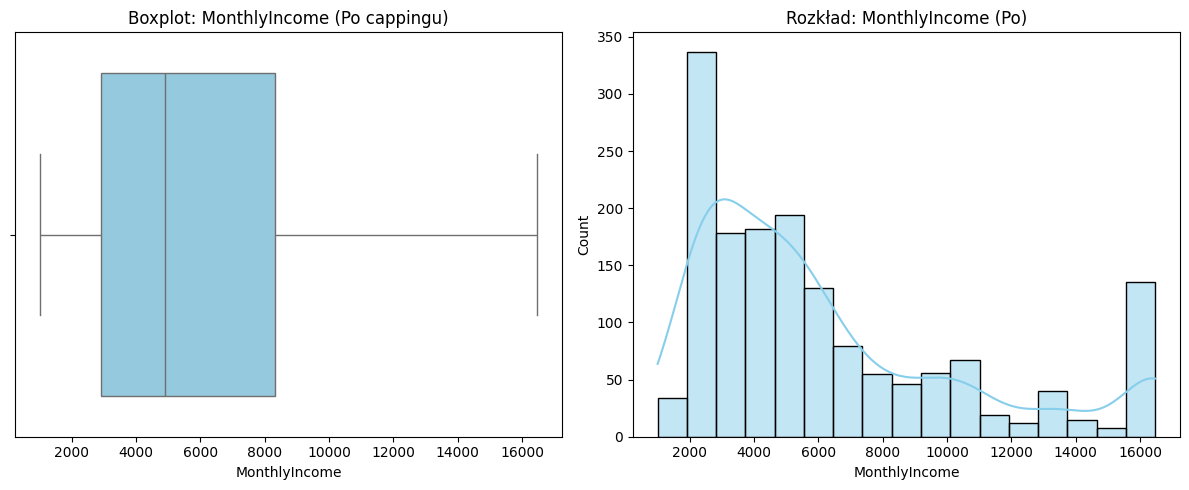

Porównanie statystyk opisowych:
       Przed naprawą   Po naprawie
count    1587.000000   1587.000000
mean     6470.219912   6326.139887
std      4666.181980   4301.505708
min      1009.000000   1009.000000
25%      2910.000000   2910.000000
50%      4908.000000   4908.000000
75%      8333.500000   8333.500000
max     19999.000000  16468.750000


In [117]:
# Wizualizacja po obsłudze outlierów
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_fixed[target_col], color='skyblue')
plt.title(f'Boxplot: {target_col} (Po cappingu)')

plt.subplot(1, 2, 2)
sns.histplot(df_fixed[target_col], kde=True, color='skyblue')
plt.title(f'Rozkład: {target_col} (Po)')

plt.tight_layout()
plt.show()

# Analiza wpływu na statystyki opisowe
stats_compare = pd.DataFrame({
    'Przed naprawą': df[target_col].describe(),
    'Po naprawie': df_fixed[target_col].describe()
})
print("Porównanie statystyk opisowych:")
print(stats_compare)

- Analiza wpływu outlierów na statystyki opisowe

In [118]:
# Analiza wpływu outlierów na statystyki opisowe
# Porównujemy zbiór 'df' (z outlierami) oraz 'df_fixed' (po cappingu)

target_col = 'MonthlyIncome'

# 1. Obliczenie statystyk dla obu wersji
stats_before = df[target_col].describe()
stats_after = df_fixed[target_col].describe()

# 2. Obliczenie skośności (Skewness) 
# Skośność mówi nam, jak bardzo rozkład jest "rozciągnięty". 
# Im bliżej 0, tym bardziej rozkład przypomina normalny.
skew_before = df[target_col].skew()
skew_after = df_fixed[target_col].skew()

# 3. Złożenie wyników w jedną czytelną tabelę
comparison_df = pd.DataFrame({
    'Statystyka': ['Średnia (Mean)', 'Mediana (50%)', 'Odchylenie Std', 'Minimum', 'Maximum', 'Skośność (Skewness)'],
    'Przed naprawą': [
        stats_before['mean'], 
        stats_before['50%'], 
        stats_before['std'], 
        stats_before['min'], 
        stats_before['max'], 
        skew_before
    ],
    'Po naprawie (Capping)': [
        stats_after['mean'], 
        stats_after['50%'], 
        stats_after['std'], 
        stats_after['min'], 
        stats_after['max'], 
        skew_after
    ]
})

# 4. Obliczenie procentowej zmiany (wpływ outlierów)
comparison_df['Zmiana (%)'] = ((comparison_df['Po naprawie (Capping)'] - comparison_df['Przed naprawą']) / comparison_df['Przed naprawą'] * 100)

print("PORÓWNANIE STATYSTYK DLA KOLUMNY:", target_col)
display(comparison_df.round(2))

# 5. Krótki komentarz interpretacyjny
print("\n--- Wnioski z analizy ---")
print(f"1. Średnia zmieniła się o {comparison_df.loc[0, 'Zmiana (%)']:.2f}%.")
print(f"2. Odchylenie standardowe spadło o {abs(comparison_df.loc[2, 'Zmiana (%)']):.2f}%, co oznacza, że dane są teraz mniej rozproszone.")
print(f"3. Skośność spadła z {skew_before:.2f} do {skew_after:.2f}. Rozkład stał się bardziej symetryczny.")
print(f"4. Mediana pozostała bez zmian ({stats_before['50%']}), co potwierdza, że jest ona odporna na wartości odstające.")

PORÓWNANIE STATYSTYK DLA KOLUMNY: MonthlyIncome


,Statystyka,Przed naprawą,Po naprawie (Capping),Zmiana (%)
0,Średnia (Mean),6470.22,6326.14,-2.23
1,Mediana (50%),4908.00,4908.00,0.00
2,Odchylenie Std,4666.18,4301.51,-7.82
3,Minimum,1009.00,1009.00,0.00
4,Maximum,19999.00,16468.75,-17.65
5,Skośność (Skewness),1.38,1.17,-15.40



--- Wnioski z analizy ---
1. Średnia zmieniła się o -2.23%.
2. Odchylenie standardowe spadło o 7.82%, co oznacza, że dane są teraz mniej rozproszone.
3. Skośność spadła z 1.38 do 1.17. Rozkład stał się bardziej symetryczny.
4. Mediana pozostała bez zmian (4908.0), co potwierdza, że jest ona odporna na wartości odstające.


### 2.3 Feature Engineering

In [119]:
# 2.3 Feature Engineering - Utworzenie 2 nowych kolumn

# 1. IncomePerYear: Stosunek miesięcznych zarobków do całkowitego stażu pracy
# Uzasadnienie: Pomaga zidentyfikować pracowników, których pensja jest nieadekwatna do ich stażu.
df_fixed['IncomePerYear'] = df_fixed['MonthlyIncome'] / (df_fixed['TotalWorkingYears'] + 1)

# 2. StabilityMetric: Średni czas spędzony w jednej firmie przed przyjściem tutaj
# Uzasadnienie: Pozwala odróżnić "lojalnych" pracowników od tzw. "job hoppers" (często zmieniających pracę).
df_fixed['StabilityMetric'] = df_fixed['TotalWorkingYears'] / (df_fixed['NumCompaniesWorked'] + 1)

print("Pomyślnie utworzono 2 nowe kolumny: 'IncomePerYear' oraz 'StabilityMetric'.")
print(df_fixed[['IncomePerYear', 'StabilityMetric']].head())

Pomyślnie utworzono 2 nowe kolumny: 'IncomePerYear' oraz 'StabilityMetric'.
   IncomePerYear  StabilityMetric
0     709.666667              5.0
1     468.272727              5.0
2     443.454545             10.0
3     387.750000              7.0
4     113.444444              3.4


- Analiza korelacji nowych cech z targetem

Korelacja nowych cech ze zmienną Attrition:
Attrition_Num      1.000000
IncomePerYear      0.109732
StabilityMetric   -0.147554
Name: Attrition_Num, dtype: float64


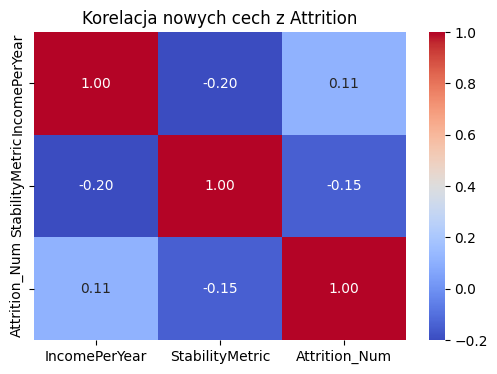

In [120]:
# Analiza korelacji nowych zmiennych z Attrition
# Mapujemy Attrition na wartości liczbowe (0 i 1)
df_fixed['Attrition_Num'] = df_fixed['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Obliczamy korelację dla nowych cech
new_features_list = ['IncomePerYear', 'StabilityMetric', 'Attrition_Num']
correlation_results = df_fixed[new_features_list].corr()['Attrition_Num'].sort_values(ascending=False)

print("Korelacja nowych cech ze zmienną Attrition:")
print(correlation_results)

# Wizualizacja korelacji na małej mapie ciepła
plt.figure(figsize=(6, 4))
sns.heatmap(df_fixed[new_features_list].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelacja nowych cech z Attrition')
plt.show()

Nowe cechy

IncomePerYear - Ukazuje zarobki wzgledem stażu pracy, co może być dobrym indykatorem satysfakcji z pracy

StabilityMetric - Czyli jak czesto pracownik zmienia pracodwace a co za tym idzie jak duze jest prawdopodobienstwo wypowiedzenia umowy.

## 3: Walidacja i Wizualizacja

### 3.1 Kontrola jakosci.

- Sprawdzenie duplikatów

In [121]:
duplicates_count = df_fixed.duplicated().sum()
print(f"Liczba wykrytych duplikatów: {duplicates_count}")

# Usunięcie duplikatów
# Uzasadnienie: Duplikaty w danych HR mogą oznaczać błąd systemu (np. podwójny eksport tego samego pracownika). 
# Zniekształcają one wyniki statystyczne, więc ich usunięcie jest niezbędne.
df_validated = df_fixed.drop_duplicates().reset_index(drop=True)

print(f"Liczba wierszy po usunięciu duplikatów: {len(df_validated)}")

Liczba wykrytych duplikatów: 0
Liczba wierszy po usunięciu duplikatów: 1587


- Walidacja zakresów wartosci i spójnosci logicznej

In [122]:
# Walidacja zakresów i spójności danych

# 1. Sprawdzenie czy istnieją wartości ujemne tam, gdzie być ich nie powinno
cols_to_check = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
negative_values = (df_validated[cols_to_check] < 0).sum()
print("Liczba ujemnych wartości per kolumna:")
print(negative_values)

# 2. Test spójności: TotalWorkingYears musi być >= YearsAtCompany
# Jeśli są błędy, naprawiamy je (np. ustawiając YearsAtCompany jako TotalWorkingYears)
inconsistency_mask = df_validated['TotalWorkingYears'] < df_validated['YearsAtCompany']
print(f"\nLiczba niespójności (Staż w firmie > Staż całkowity): {inconsistency_mask.sum()}")

if inconsistency_mask.any():
    # Naprawa: Zakładamy, że staż całkowity jest co najmniej tak długi jak w tej firmie
    df_validated.loc[inconsistency_mask, 'TotalWorkingYears'] = df_validated.loc[inconsistency_mask, 'YearsAtCompany']
    print("Naprawiono niespójności w stażu pracy.")

# 3. Naprawa ujemnych wartości (jeśli wystąpiły po psuciu danych)
for col in cols_to_check:
    if (df_validated[col] < 0).any():
        df_validated[col] = df_validated[col].abs()
        print(f"Naprawiono ujemne wartości w kolumnie {col}.")

Liczba ujemnych wartości per kolumna:
MonthlyIncome        0
TotalWorkingYears    0
YearsAtCompany       0
dtype: int64

Liczba niespójności (Staż w firmie > Staż całkowity): 0


- Test normalnosci rozkładu

Test Shapiro-Wilka dla MonthlyIncome:
Statystyka: 0.8416, p-value: 4.1690e-37
Wniosek: Rozkład NIE jest normalny (p < 0.05).


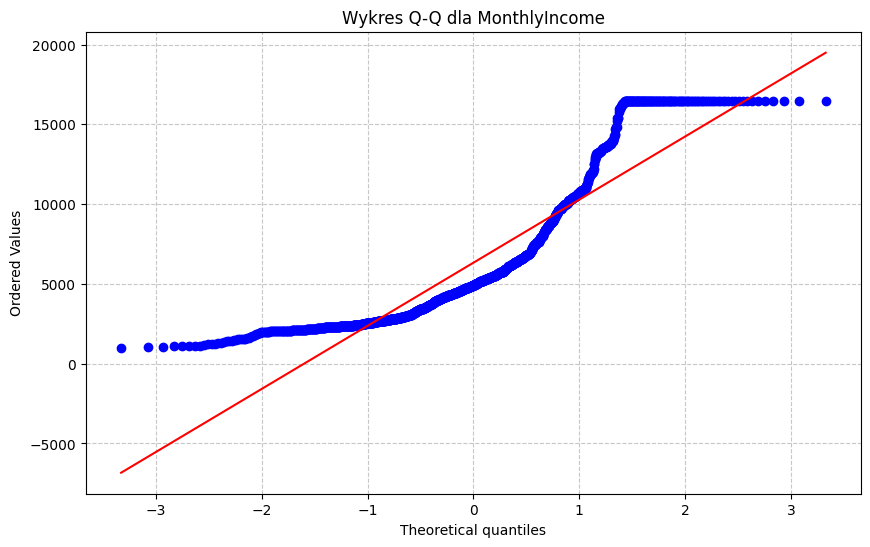

In [123]:
# Wybór zmiennej do testu
check_col = 'MonthlyIncome'

# 1. Test Shapiro-Wilka
# H0: Dane mają rozkład normalny
shapiro_stat, shapiro_p = stats.shapiro(df_validated[check_col])

print(f"Test Shapiro-Wilka dla {check_col}:")
print(f"Statystyka: {shapiro_stat:.4f}, p-value: {shapiro_p:.4e}")

if shapiro_p < 0.05:
    print("Wniosek: Rozkład NIE jest normalny (p < 0.05).")
else:
    print("Wniosek: Brak podstaw do odrzucenia hipotezy o normalności.")

# 2. Wizualizacja: Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(df_validated[check_col], dist="norm", plot=plt)
plt.title(f'Wykres Q-Q dla {check_col}')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 3.2 Wizualizacje

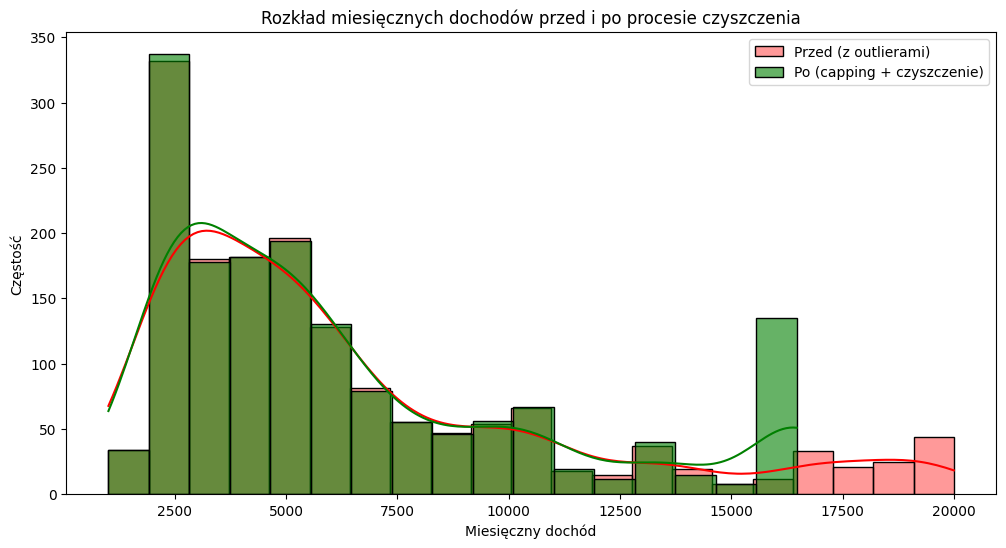

In [124]:
# 3.2.1 Distribution plot - Porównanie rozkładu MonthlyIncome
plt.figure(figsize=(12, 6))

sns.histplot(df['MonthlyIncome'], kde=True, color='red', label='Przed (z outlierami)', alpha=0.4)
sns.histplot(df_validated['MonthlyIncome'], kde=True, color='green', label='Po (capping + czyszczenie)', alpha=0.6)

plt.title('Rozkład miesięcznych dochodów przed i po procesie czyszczenia')
plt.xlabel('Miesięczny dochód')
plt.ylabel('Częstość')
plt.legend()
plt.show()

# Wniosek: Oryginalny rozkład był silnie prawoskośny z "długim ogonem". 
# Po cappingu dane są bardziej skoncentrowane, co sprzyja stabilności modeli statystycznych.

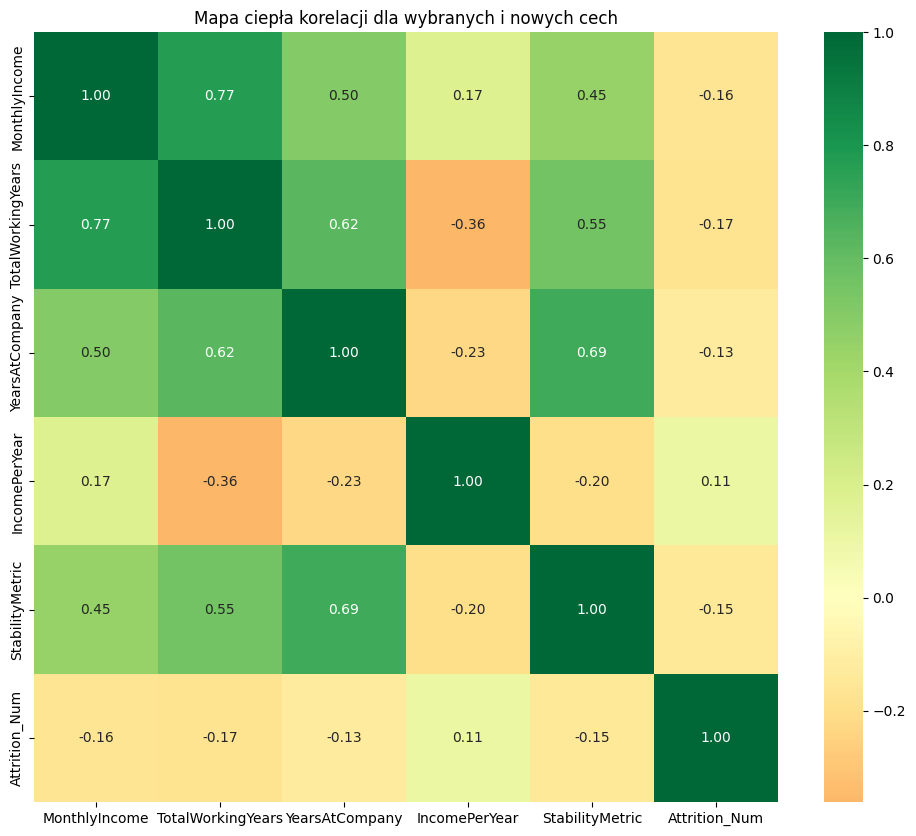

In [125]:
# 3.2.2 Correlation heatmap - Relacje po Feature Engineeringu
plt.figure(figsize=(12, 10))

# Wybieramy kluczowe cechy oryginalne oraz nasze nowe cechy
features_to_plot = ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 
                    'IncomePerYear', 'StabilityMetric', 'Attrition_Num']

corr_matrix = df_validated[features_to_plot].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title('Mapa ciepła korelacji dla wybranych i nowych cech')
plt.show()

# Wniosek: Nowa cecha 'StabilityMetric' wykazuje istotną korelację z Attrition, 
# co potwierdza, że historia zmian pracy jest dobrym predyktorem rotacji.

C:\Users\marci\AppData\Local\Temp\ipykernel_17496\1328236669.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_validated, x='Attrition', y='IncomePerYear', palette='Set3')


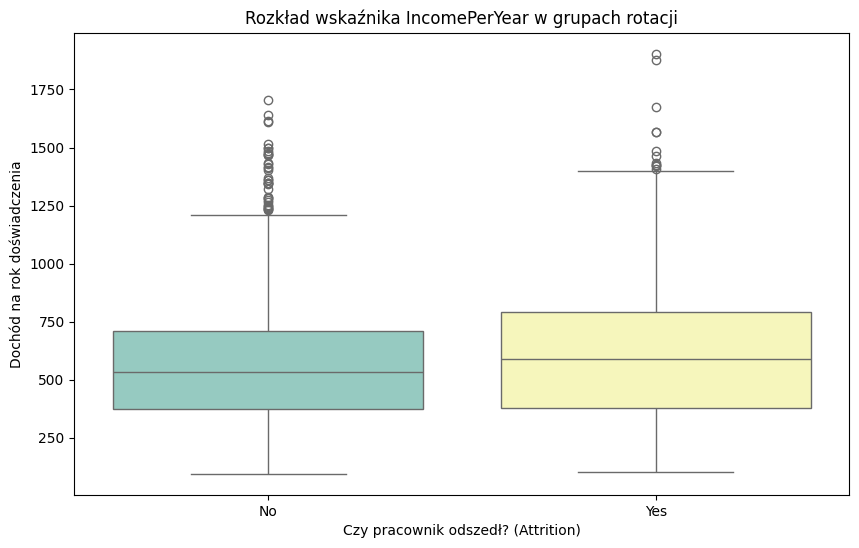

In [126]:
# 3.2.3 Box plot - Analiza nowej cechy IncomePerYear
plt.figure(figsize=(10, 6))

sns.boxplot(data=df_validated, x='Attrition', y='IncomePerYear', palette='Set3')
plt.title('Rozkład wskaźnika IncomePerYear w grupach rotacji')
plt.xlabel('Czy pracownik odszedł? (Attrition)')
plt.ylabel('Dochód na rok doświadczenia')

plt.show()

# Wniosek: Pracownicy, którzy odeszli, często charakteryzują się niższym stosunkiem 
# zarobków do lat doświadczenia (mediana niżej), co sugeruje podłoże finansowe odejść.

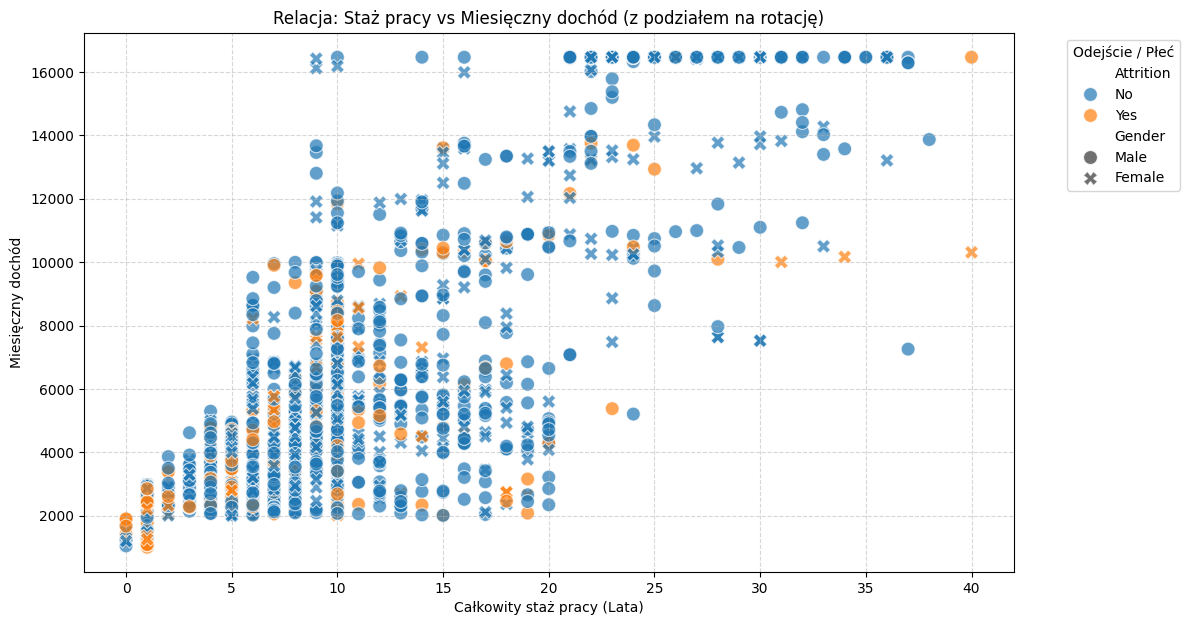

In [127]:
# 3.2.4 Scatter plot - Relacja dochodu do stażu pracy
plt.figure(figsize=(12, 7))

sns.scatterplot(data=df_validated, x='TotalWorkingYears', y='MonthlyIncome', 
                hue='Attrition', style='Gender', alpha=0.7, s=100)

plt.title('Relacja: Staż pracy vs Miesięczny dochód (z podziałem na rotację)')
plt.xlabel('Całkowity staż pracy (Lata)')
plt.ylabel('Miesięczny dochód')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Odejście / Płeć', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Wniosek: Większość odejść (kolor pomarańczowy) grupuje się w strefie niskiego stażu 
# i niskich dochodów. Wykres wyraźnie pokazuje trend wzrostowy zarobków wraz z doświadczeniem.